In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Dataset, random_split

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.linalg import sqrtm
import numpy as np
import os
from PIL import Image
from sklearn.manifold import TSNE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


2.1.1

In [8]:
810103322 % 3 # student number

2

In [3]:
label_string_to_number = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
label_number_to_string = {value: key for key, value in label_string_to_number.items()}

domain_to_number = {'art_painting': 0, 'cartoon':1, 'photo':2, 'sketch':3}

In [4]:
dataset_path = '/kaggle/input/pacs-dataset/kfold'
ds_dict = {}
for domain in os.listdir(dataset_path):
    images_list = []
    domain_path = os.path.join(dataset_path, domain)
    for class_name in os.listdir(domain_path): 
        class_path = os.path.join(domain_path, class_name)
        num_images = len(os.listdir(class_path)) 
        print(f"Domain: {domain:<15}  Class: {class_name:<10}\t Number of images: {num_images:<5}")
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            images_list.append((image_path, label_string_to_number[class_name], domain_to_number[domain]))
    ds_dict[domain] = images_list

Domain: cartoon          Class: horse     	 Number of images: 324  
Domain: cartoon          Class: dog       	 Number of images: 389  
Domain: cartoon          Class: house     	 Number of images: 288  
Domain: cartoon          Class: guitar    	 Number of images: 135  
Domain: cartoon          Class: elephant  	 Number of images: 457  
Domain: cartoon          Class: giraffe   	 Number of images: 346  
Domain: cartoon          Class: person    	 Number of images: 405  
Domain: sketch           Class: horse     	 Number of images: 816  
Domain: sketch           Class: dog       	 Number of images: 772  
Domain: sketch           Class: house     	 Number of images: 80   
Domain: sketch           Class: guitar    	 Number of images: 608  
Domain: sketch           Class: elephant  	 Number of images: 740  
Domain: sketch           Class: giraffe   	 Number of images: 753  
Domain: sketch           Class: person    	 Number of images: 160  
Domain: art_painting     Class: horse     	 Numb

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
class DomainDataset(Dataset):
    def __init__(self, domain_list, transform=None):
        self.transform = transform
        self.domain_list = domain_list
    
    def __len__(self):
        return len(self.domain_list)
    
    def __getitem__(self, index):
        img_path = self.domain_list[index][0]
        label = self.domain_list[index][1]
        domain = self.domain_list[index][2] 
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label, domain

In [7]:
art_painting_dataset = DomainDataset(ds_dict['art_painting'], transform=transform)
cartoon_dataset = DomainDataset(ds_dict['cartoon'], transform=transform)
photo_dataset = DomainDataset(ds_dict['photo'], transform=transform)
sketch_dataset = DomainDataset(ds_dict['sketch'], transform=transform)

ratio = 0.8

art_painting_train, art_painting_test = random_split(art_painting_dataset, [0.8,0.2])
cartoon_train, cartoon_test = random_split(cartoon_dataset, [0.8,0.2])
photo_train, photo_test = random_split(photo_dataset, [0.8,0.2])
sketch_train, sketch_test = random_split(sketch_dataset, [0.8,0.2])


batch_size = 32
art_painting_train_loader = DataLoader(art_painting_train, batch_size=batch_size, shuffle=True)
art_painting_test_loader = DataLoader(art_painting_test, batch_size=batch_size, shuffle=False)

cartoon_train_loader = DataLoader(cartoon_train, batch_size=batch_size, shuffle=True)
cartoon_test_loader = DataLoader(cartoon_test, batch_size=batch_size, shuffle=False)

photo_train_loader = DataLoader(photo_train, batch_size=batch_size, shuffle=True)
photo_test_loader = DataLoader(photo_test, batch_size=batch_size, shuffle=False)

sketch_train_loader = DataLoader(sketch_train, batch_size=batch_size, shuffle=True)
sketch_test_loader = DataLoader(sketch_test, batch_size=batch_size, shuffle=False)

In [10]:
resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

2.1.2

In [8]:
def evaluate_accuracy(loader, model):
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels, _ in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [17]:
def train_model(model, train_loaders, test_loaders, optimizer, criterion, epochs):
    train_losses = []
    train_accuracies = []
    train_domain_losses = []  # per domain
    train_domain_accuracies = []  
    test_losses = []
    test_accuracies = []
    test_domain_losses = [] 
    test_domain_accuracies = []  

    for epoch in range(epochs):
        # train
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        loader_losses = [0] * len(train_loaders)
        loader_corrects = [0] * len(train_loaders)
        loader_samples = [0] * len(train_loaders)

        for batch_group in zip(*train_loaders):
            for loader_idx, (images, labels, _) in enumerate(batch_group):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()

                loader_losses[loader_idx] += loss.item()
                _, preds = outputs.max(1)
                loader_corrects[loader_idx] += preds.eq(labels).sum().item()
                loader_samples[loader_idx] += labels.size(0)

                total_loss += loss.item()
                total_correct += preds.eq(labels).sum().item()
                total_samples += labels.size(0)

            optimizer.step()  # update weights after processing all domains' batches in each epoch
            optimizer.zero_grad()

        loader_avg_losses = [loss / loader_samples[idx] if loader_samples[idx] > 0 else 0
                             for idx, loss in enumerate(loader_losses)]
        loader_accuracies = [correct / loader_samples[idx] if loader_samples[idx] > 0 else 0
                             for idx, correct in enumerate(loader_corrects)]

        total_avg_loss = total_loss / total_samples
        total_accuracy = total_correct / total_samples

        train_losses.append(total_avg_loss)
        train_accuracies.append(total_accuracy)
        train_domain_losses.append(loader_avg_losses)
        train_domain_accuracies.append(loader_accuracies)

        print(f"epoch {epoch + 1}/{epochs}:")
        print('train data')
        for idx, (loss, acc) in enumerate(zip(loader_avg_losses, loader_accuracies)):
            print(f" train domain {idx + 1}: loss = {loss:.4f}, accuracy = {acc:.4%}")
        print(f" *train total: loss = {total_avg_loss:.4f}, accuracy = {total_accuracy:.4%}")

        # test
        model.eval()
        with torch.no_grad():
            test_loader_losses = [0] * len(test_loaders)
            test_loader_corrects = [0] * len(test_loaders)
            test_loader_samples = [0] * len(test_loaders)

            for loader_idx, loader in enumerate(test_loaders):
                for images, labels, _ in loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    test_loader_losses[loader_idx] += loss.item()
                    _, preds = outputs.max(1)
                    test_loader_corrects[loader_idx] += preds.eq(labels).sum().item()
                    test_loader_samples[loader_idx] += labels.size(0)

            test_loader_avg_losses = [loss / test_loader_samples[idx] if test_loader_samples[idx] > 0 else 0
                               for idx, loss in enumerate(test_loader_losses)]
            test_loader_accuracies = [correct / test_loader_samples[idx] if test_loader_samples[idx] > 0 else 0
                               for idx, correct in enumerate(test_loader_corrects)]

            total_test_loss = sum(test_loader_losses) / sum(test_loader_samples)
            total_test_accuracy = sum(test_loader_corrects) / sum(test_loader_samples)

            test_losses.append(total_test_loss)
            test_accuracies.append(total_test_accuracy)
            test_domain_losses.append(test_loader_avg_losses)
            test_domain_accuracies.append(test_loader_accuracies)

            print('-------------------------------------------\n test data:')
            for idx, (loss, acc) in enumerate(zip(test_loader_avg_losses, test_loader_accuracies)):
                print(f" test domain {idx + 1}: loss = {loss:.4f}, accuracy = {acc:.4%}")
            print(f" *test total: loss = {total_test_loss:.4f}, accuracy = {total_test_accuracy:.4%}")
            print('===========================================')

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_domain_losses": train_domain_losses,
        "train_domain_accuracies": train_domain_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies,
        "test_domain_losses": test_domain_losses,
        "test_domain_accuracies": test_domain_accuracies,
    }

In [9]:
def plot_results(results, train_domains, test_domains):

    train_losses = results["train_losses"]
    train_accuracies = results["train_accuracies"]
    train_domain_losses = results["train_domain_losses"]
    train_domain_accuracies = results["train_domain_accuracies"]
    test_losses = results["test_losses"]
    test_accuracies = results["test_accuracies"]
    test_domain_losses = results["test_domain_losses"]
    test_domain_accuracies = results["test_domain_accuracies"]

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, label="Total Train Loss", color='blue', marker='o')
    for idx, domain in enumerate(train_domains):
        domain_losses = [epoch_losses[idx] for epoch_losses in train_domain_losses]
        plt.plot(epochs, domain_losses, label=f"{domain} Train Loss", linestyle='--')
    plt.title("Training Loss (Total and Domain-Specific)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracies, label="Total Train Accuracy", color='blue', marker='o')
    for idx, domain in enumerate(train_domains):
        domain_accuracies = [epoch_accuracies[idx] for epoch_accuracies in train_domain_accuracies]
        plt.plot(epochs, domain_accuracies, label=f"{domain} Train Accuracy", linestyle='--')
    plt.title("Training Accuracy (Total and Domain-Specific)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, test_losses, label="Total Test Loss", color='orange', marker='o')
    for idx, domain in enumerate(test_domains):
        domain_losses = [epoch_losses[idx] for epoch_losses in test_domain_losses]
        plt.plot(epochs, domain_losses, label=f"{domain} Test Loss", linestyle=':')
    plt.title("Testing Loss (Total and Domain-Specific)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, test_accuracies, label="Total Test Accuracy", color='orange', marker='o')
    for idx, domain in enumerate(test_domains):
        domain_accuracies = [epoch_accuracies[idx] for epoch_accuracies in test_domain_accuracies]
        plt.plot(epochs, domain_accuracies, label=f"{domain} Test Accuracy", linestyle=':')
    plt.title("Testing Accuracy (Total and Domain-Specific)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

epoch 1/40:
train data
 train domain 1: loss = 0.0596, accuracy = 22.9911%
 train domain 2: loss = 0.0622, accuracy = 18.3036%
 train domain 3: loss = 0.0607, accuracy = 21.5569%
 *train total: loss = 0.0608, accuracy = 20.9493%
-------------------------------------------
 test data:
 test domain 1: loss = 0.0615, accuracy = 23.2274%
 test domain 2: loss = 0.0607, accuracy = 26.4957%
 test domain 3: loss = 0.0605, accuracy = 31.7365%
 test domain 4: loss = 0.0646, accuracy = 10.1911%
 *test total: loss = 0.0624, accuracy = 20.2906%
epoch 2/40:
train data
 train domain 1: loss = 0.0553, accuracy = 34.4494%
 train domain 2: loss = 0.0572, accuracy = 27.0089%
 train domain 3: loss = 0.0533, accuracy = 42.3653%
 *train total: loss = 0.0553, accuracy = 34.5924%
-------------------------------------------
 test data:
 test domain 1: loss = 0.0585, accuracy = 29.3399%
 test domain 2: loss = 0.0581, accuracy = 31.1966%
 test domain 3: loss = 0.0538, accuracy = 46.7066%
 test domain 4: loss = 0

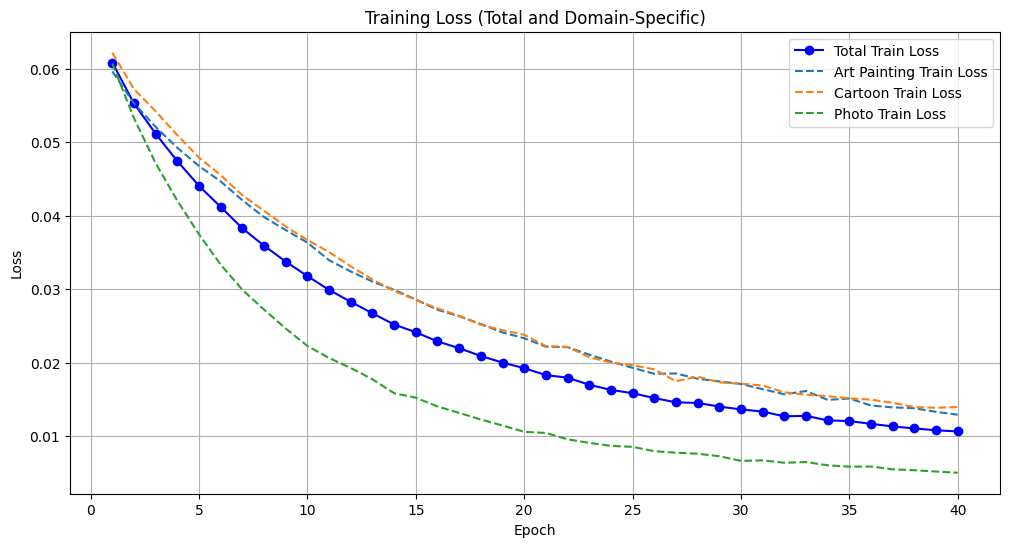

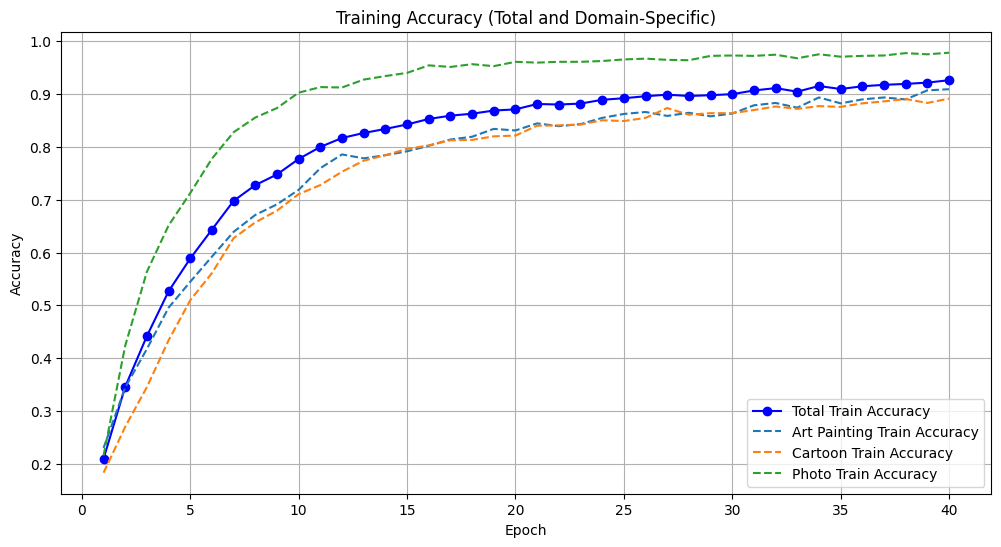

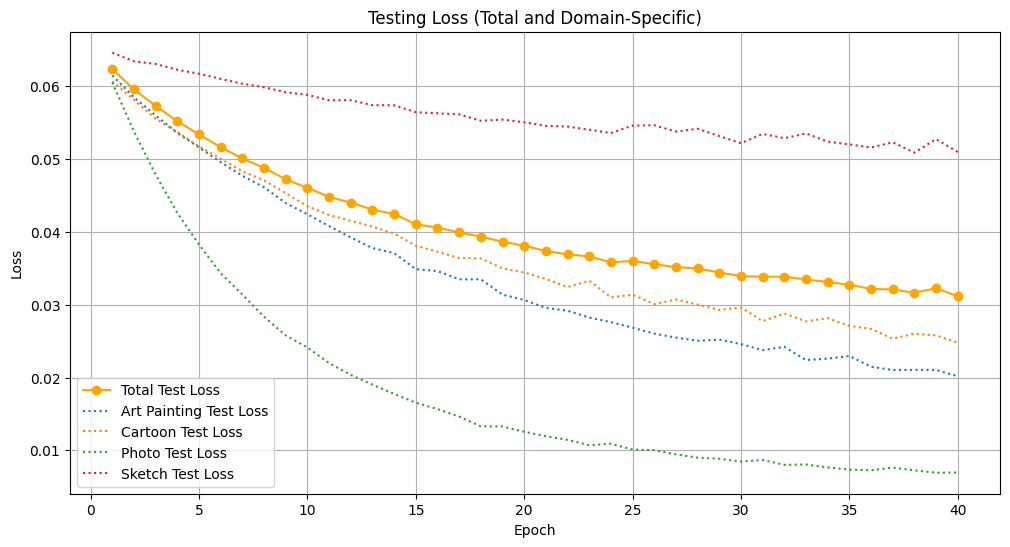

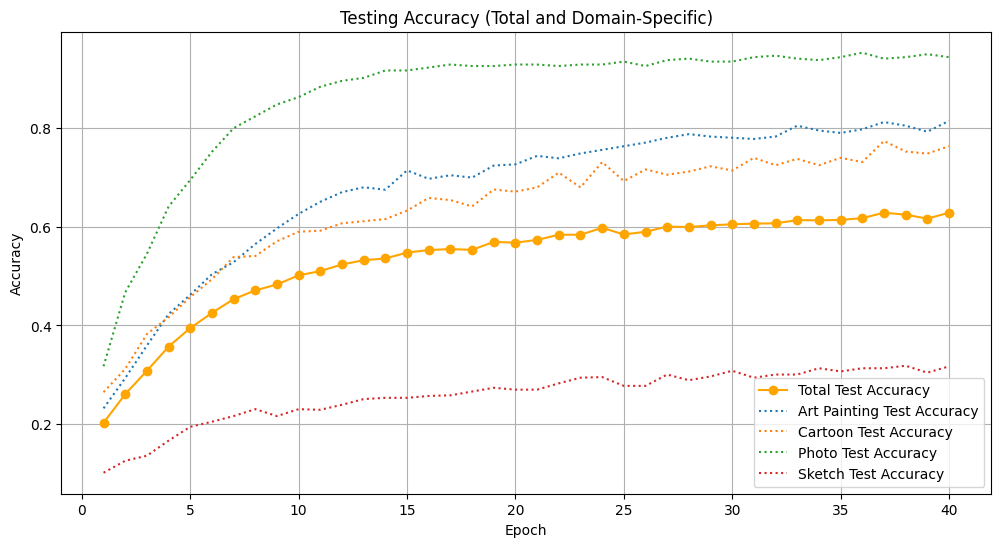

In [31]:
resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.0002
optimizer = optim.SGD(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_domains = ["Art Painting", "Cartoon", "Photo"]
test_domains = ["Art Painting", "Cartoon", "Photo", "Sketch"]

train_loaders = [art_painting_train_loader, cartoon_train_loader, photo_train_loader]
test_loaders = [art_painting_test_loader, cartoon_test_loader, photo_test_loader, sketch_test_loader]

results = train_model(resnet, train_loaders, test_loaders, optimizer, criterion, 40)


plot_results(results, train_domains, test_domains)

In [33]:
def freeze_batchnorm_layers(model):
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            module.eval() 
            for param in module.parameters():
                param.requires_grad = False 

epoch 1/40:
train data
 train domain 1: loss = 0.0620, accuracy = 19.7917%
 train domain 2: loss = 0.0607, accuracy = 17.6339%
 train domain 3: loss = 0.0645, accuracy = 12.9491%
 *train total: loss = 0.0624, accuracy = 16.7992%
-------------------------------------------
 test data:
 test domain 1: loss = 0.0611, accuracy = 26.8949%
 test domain 2: loss = 0.0631, accuracy = 16.6667%
 test domain 3: loss = 0.0613, accuracy = 26.0479%
 test domain 4: loss = 0.0619, accuracy = 18.8535%
 *test total: loss = 0.0619, accuracy = 21.1924%
epoch 2/40:
train data
 train domain 1: loss = 0.0581, accuracy = 26.1905%
 train domain 2: loss = 0.0571, accuracy = 24.3304%
 train domain 3: loss = 0.0558, accuracy = 35.0299%
 *train total: loss = 0.0570, accuracy = 28.5040%
-------------------------------------------
 test data:
 test domain 1: loss = 0.0584, accuracy = 29.5844%
 test domain 2: loss = 0.0602, accuracy = 23.0769%
 test domain 3: loss = 0.0545, accuracy = 42.2156%
 test domain 4: loss = 0

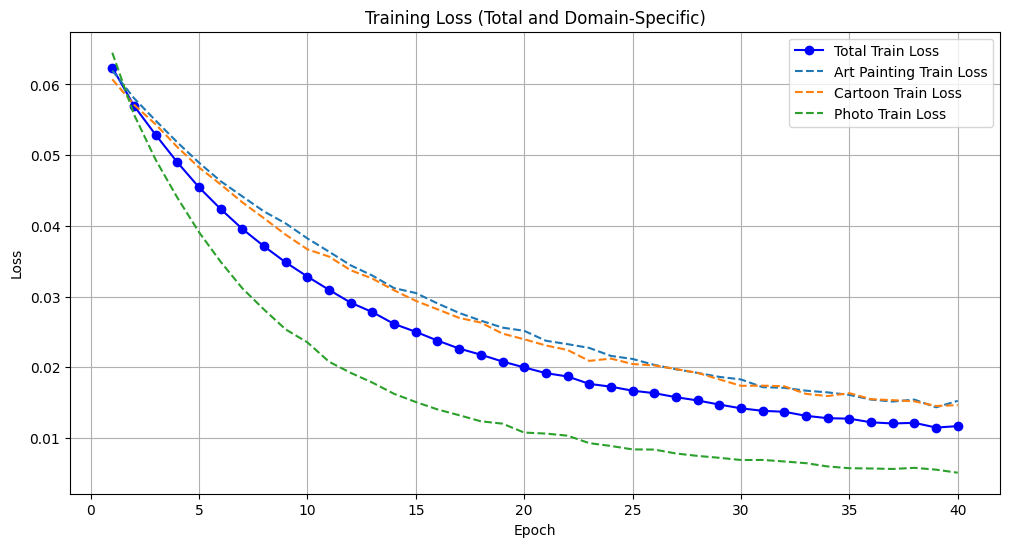

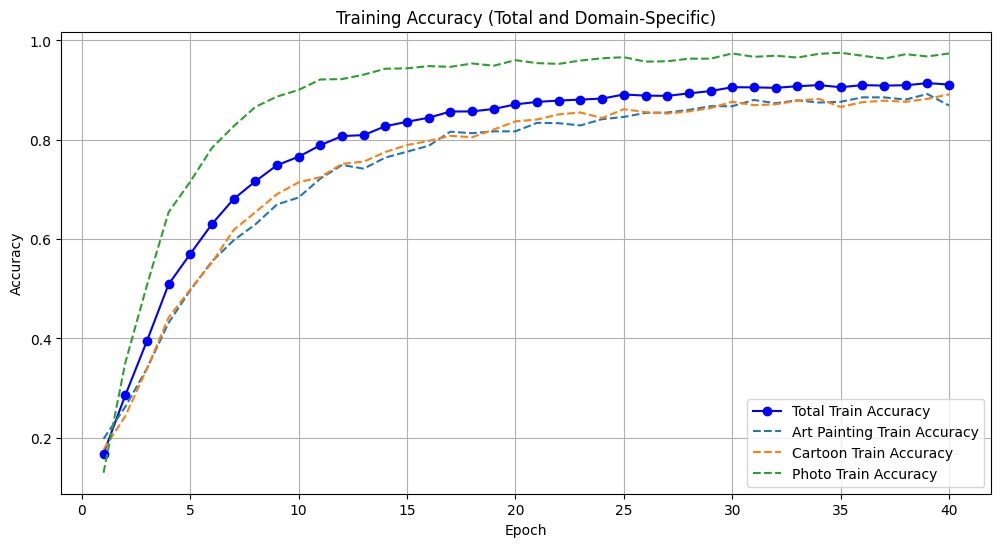

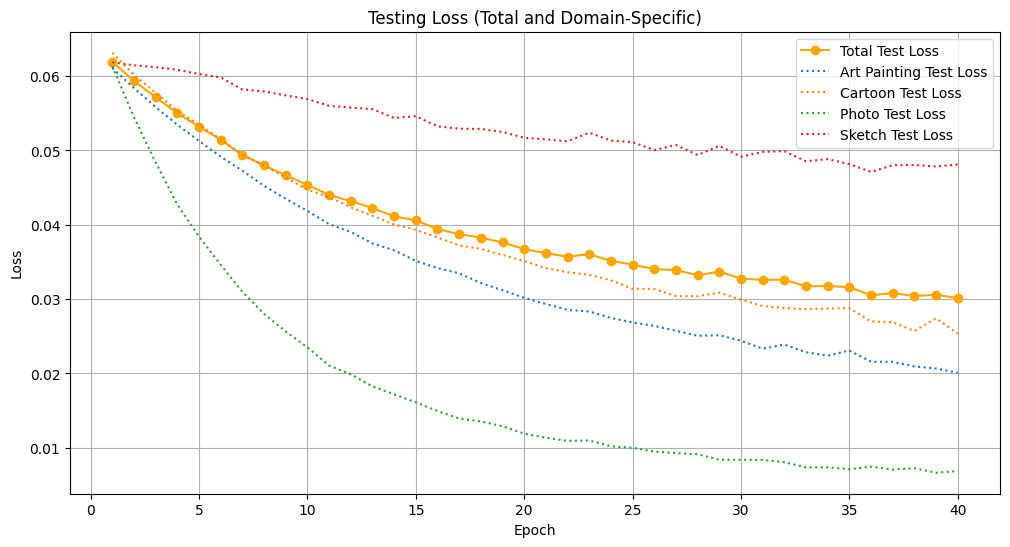

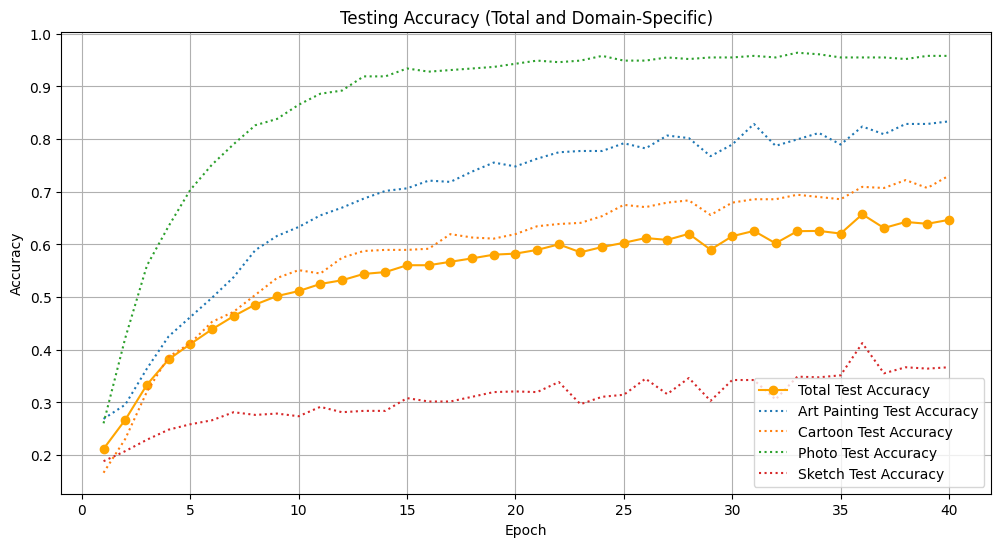

In [34]:
resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)


freeze_batchnorm_layers(resnet)

lr = 0.0002
optimizer = optim.SGD(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_domains = ["Art Painting", "Cartoon", "Photo"]
test_domains = ["Art Painting", "Cartoon", "Photo", "Sketch"]

train_loaders = [art_painting_train_loader, cartoon_train_loader, photo_train_loader]
test_loaders = [art_painting_test_loader, cartoon_test_loader, photo_test_loader, sketch_test_loader]

results = train_model(resnet, train_loaders, test_loaders, optimizer, criterion, 40)

plot_results(results, train_domains, test_domains)

epoch 1/40:
train data
 train domain 1: loss = 0.0261, accuracy = 73.0655%
 train domain 2: loss = 0.0213, accuracy = 77.0089%
 train domain 3: loss = 0.0130, accuracy = 84.8802%
 *train total: loss = 0.0202, accuracy = 78.3052%
-------------------------------------------
 test data:
 test domain 1: loss = 0.0237, accuracy = 75.0611%
 test domain 2: loss = 0.0210, accuracy = 78.6325%
 test domain 3: loss = 0.0130, accuracy = 87.7246%
 test domain 4: loss = 0.0388, accuracy = 61.0191%
 *test total: loss = 0.0272, accuracy = 72.4950%
epoch 2/40:
train data
 train domain 1: loss = 0.0117, accuracy = 86.9048%
 train domain 2: loss = 0.0091, accuracy = 91.0714%
 train domain 3: loss = 0.0056, accuracy = 94.0868%
 *train total: loss = 0.0088, accuracy = 90.6809%
-------------------------------------------
 test data:
 test domain 1: loss = 0.0238, accuracy = 75.3056%
 test domain 2: loss = 0.0127, accuracy = 87.6068%
 test domain 3: loss = 0.0081, accuracy = 91.6168%
 test domain 4: loss = 0

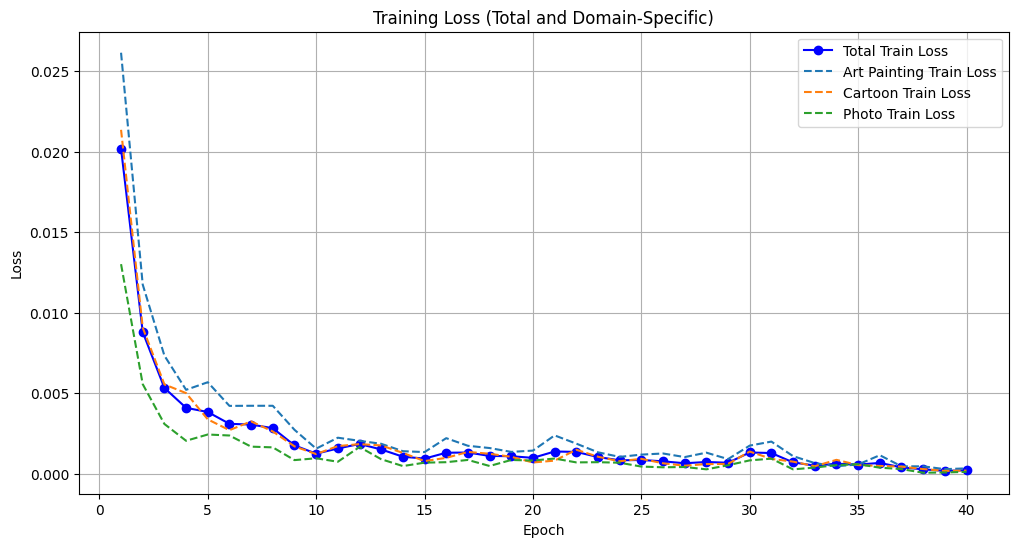

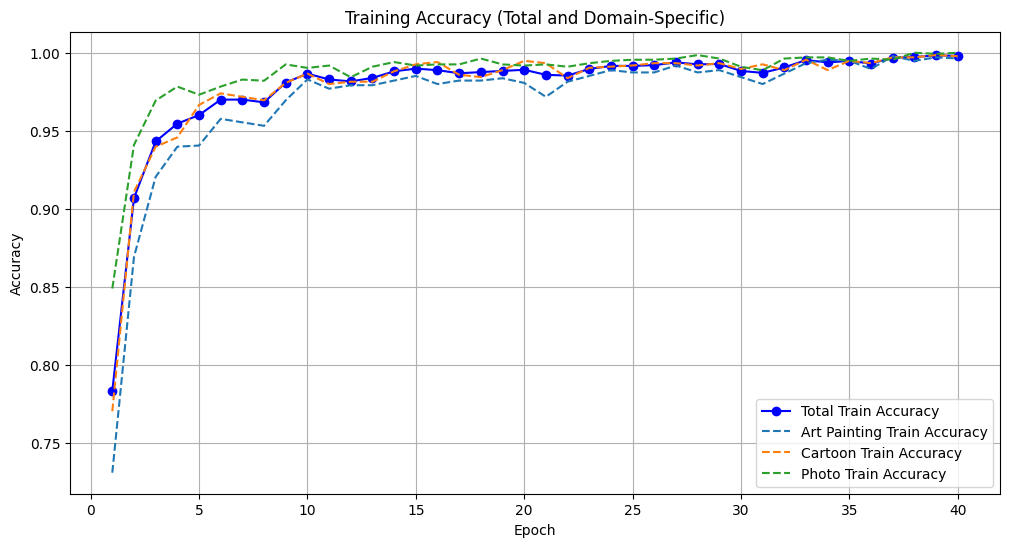

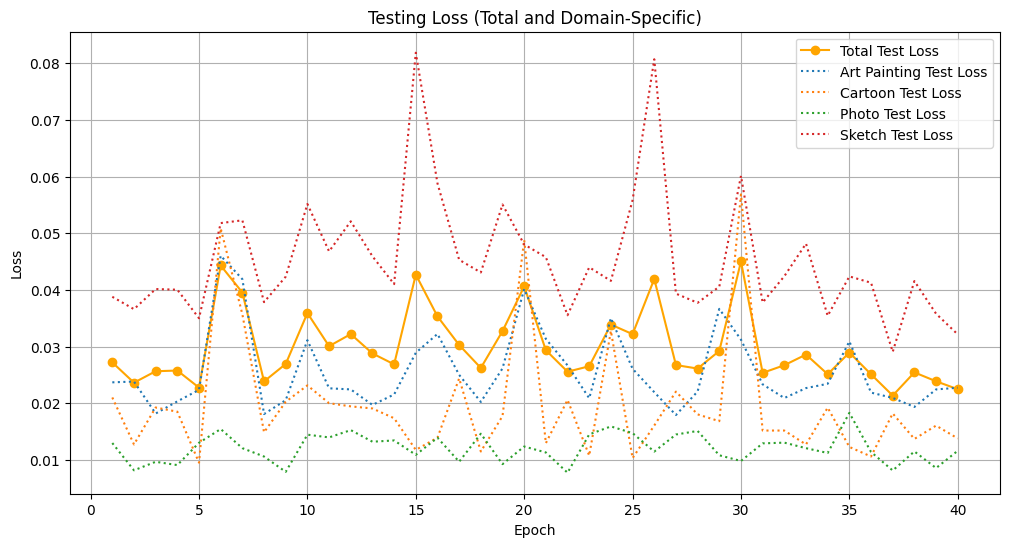

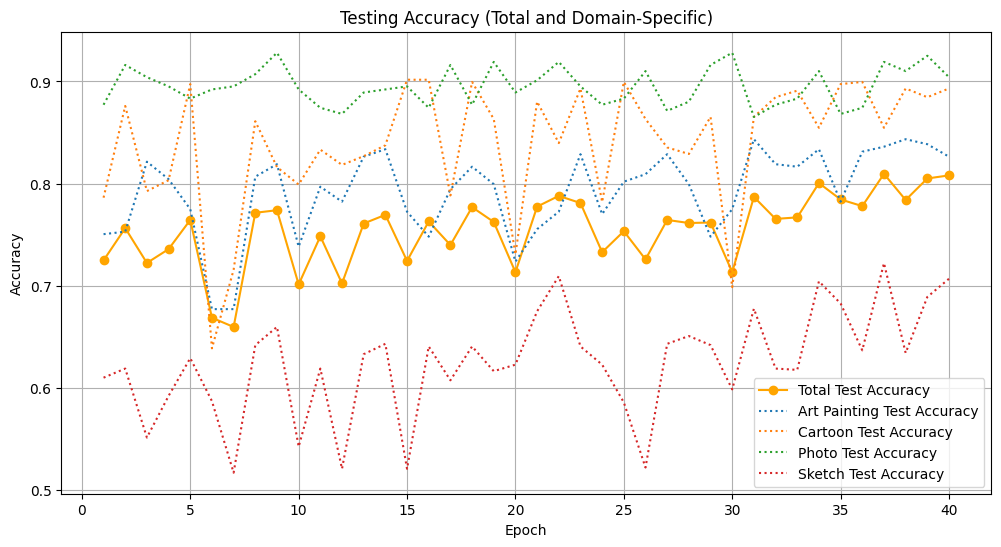

In [18]:
resnet = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 7)
resnet.to(device)

lr = 0.001
optimizer = optim.Adam(resnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_domains = ["Art Painting", "Cartoon", "Photo"]
test_domains = ["Art Painting", "Cartoon", "Photo", "Sketch"]

train_loaders = [art_painting_train_loader, cartoon_train_loader, photo_train_loader]
test_loaders = [art_painting_test_loader, cartoon_test_loader, photo_test_loader, sketch_test_loader]

results = train_model(resnet, train_loaders, test_loaders, optimizer, criterion, 40)


plot_results(results, train_domains, test_domains)

3

In [25]:
class MeanEncoder(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

class VarianceEncoder(nn.Module):
    def __init__(self, shape, init=1.0, eps = 1e-5):
        super().__init__()
        self.shape = shape
        self.init = init
        self.eps = eps

        b_shape = (1, self.shape)

        self.b = nn.Parameter(torch.full(b_shape, self.init))

    def forward(self, x):
        return F.softplus(self.b) + self.eps  # to ensure the log|cov| is valid

class MIRO(nn.Module):
    def __init__(self, me, ve):
        super().__init__()
        self.me = me
        self.ve = ve

    def forward(self, z, z_0):
        vlb = (z_0 - self.me(z)).pow(2).div(self.ve(z)) + self.ve(z).log()
        reg_loss = vlb.mean() / 2.
        return reg_loss
        
        # det = torch.logdet(self.ve(z))
        # mahal_c = (z_0 - self.me(z)) @ torch.linalg.inv(self.ve(z)) 
        # norm = torch.norm(mahal_c - (z_0 - self.me(z)), p=2, dim=1)
        # return torch.sum(det + norm)


In [11]:
class ResnetFeature(nn.Module):
    def __init__(self, resnet):
        super(ResnetFeature, self).__init__()
        self.resnet = resnet
        self.features = nn.Sequential(*list(self.resnet.children())[:-1]) 
        self.label_fc = self.resnet.fc  
               
    def forward(self, x):
        features_output = self.features(x)
        features_output =  features_output.view( features_output.size(0), -1)
        fc_output = self.label_fc(features_output)
        return fc_output, features_output

In [22]:
def train_miro(model, model_0, miro, train_loaders, test_loaders, optimizer, criterion, epochs, coef):
    train_losses = []
    train_accuracies = []
    train_domain_losses = []  # per domain
    train_domain_accuracies = []  
    test_losses = []
    test_accuracies = []
    test_domain_losses = [] 
    test_domain_accuracies = []  

    model_0.eval()
    for epoch in range(epochs):
        # train
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        loader_losses = [0] * len(train_loaders)
        loader_corrects = [0] * len(train_loaders)
        loader_samples = [0] * len(train_loaders)

        for batch_group in zip(*train_loaders):
            for loader_idx, (images, labels, _) in enumerate(batch_group):
                images, labels = images.to(device), labels.to(device)
                outputs, z = model(images)
                _ , z_0 = model_0(images)
                loss = criterion(outputs, labels) + coef * miro(z, z_0)
                loss.backward()

                loader_losses[loader_idx] += loss.item()
                _, preds = outputs.max(1)
                loader_corrects[loader_idx] += preds.eq(labels).sum().item()
                loader_samples[loader_idx] += labels.size(0)

                total_loss += loss.item()
                total_correct += preds.eq(labels).sum().item()
                total_samples += labels.size(0)

            optimizer.step()  # update weights after processing all domains' batches in each epoch
            optimizer.zero_grad()

        loader_avg_losses = [loss / loader_samples[idx] if loader_samples[idx] > 0 else 0
                             for idx, loss in enumerate(loader_losses)]
        loader_accuracies = [correct / loader_samples[idx] if loader_samples[idx] > 0 else 0
                             for idx, correct in enumerate(loader_corrects)]

        total_avg_loss = total_loss / total_samples
        total_accuracy = total_correct / total_samples

        train_losses.append(total_avg_loss)
        train_accuracies.append(total_accuracy)
        train_domain_losses.append(loader_avg_losses)
        train_domain_accuracies.append(loader_accuracies)

        print(f"epoch {epoch + 1}/{epochs}:")
        print('train data')
        for idx, (loss, acc) in enumerate(zip(loader_avg_losses, loader_accuracies)):
            print(f" train domain {idx + 1}: loss = {loss:.4f}, accuracy = {acc:.4%}")
        print(f" *train total: loss = {total_avg_loss:.4f}, accuracy = {total_accuracy:.4%}")

        # test
        model.eval()
        with torch.no_grad():
            test_loader_losses = [0] * len(test_loaders)
            test_loader_corrects = [0] * len(test_loaders)
            test_loader_samples = [0] * len(test_loaders)

            for loader_idx, loader in enumerate(test_loaders):
                for images, labels, _ in loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs, _ = model(images)
                    loss = criterion(outputs, labels) + coef * miro(z, z_0)

                    test_loader_losses[loader_idx] += loss.item()
                    _, preds = outputs.max(1)
                    test_loader_corrects[loader_idx] += preds.eq(labels).sum().item()
                    test_loader_samples[loader_idx] += labels.size(0)

            test_loader_avg_losses = [loss / test_loader_samples[idx] if test_loader_samples[idx] > 0 else 0
                               for idx, loss in enumerate(test_loader_losses)]
            test_loader_accuracies = [correct / test_loader_samples[idx] if test_loader_samples[idx] > 0 else 0
                               for idx, correct in enumerate(test_loader_corrects)]

            total_test_loss = sum(test_loader_losses) / sum(test_loader_samples)
            total_test_accuracy = sum(test_loader_corrects) / sum(test_loader_samples)

            test_losses.append(total_test_loss)
            test_accuracies.append(total_test_accuracy)
            test_domain_losses.append(test_loader_avg_losses)
            test_domain_accuracies.append(test_loader_accuracies)

            print('-------------------------------------------\n test data:')
            for idx, (loss, acc) in enumerate(zip(test_loader_avg_losses, test_loader_accuracies)):
                print(f" test domain {idx + 1}: loss = {loss:.4f}, accuracy = {acc:.4%}")
            print(f" *test total: loss = {total_test_loss:.4f}, accuracy = {total_test_accuracy:.4%}")
            print('===========================================')

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_domain_losses": train_domain_losses,
        "train_domain_accuracies": train_domain_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies,
        "test_domain_losses": test_domain_losses,
        "test_domain_accuracies": test_domain_accuracies,
    }

epoch 1/40:
train data
 train domain 1: loss = 0.0184, accuracy = 79.8363%
 train domain 2: loss = 0.0168, accuracy = 82.4405%
 train domain 3: loss = 0.0100, accuracy = 88.5479%
 *train total: loss = 0.0151, accuracy = 83.5984%
-------------------------------------------
 test data:
 test domain 1: loss = 0.0170, accuracy = 79.7066%
 test domain 2: loss = 0.0247, accuracy = 73.9316%
 test domain 3: loss = 0.0097, accuracy = 89.8204%
 test domain 4: loss = 0.0434, accuracy = 41.7834%
 *test total: loss = 0.0280, accuracy = 65.1303%
epoch 2/40:
train data
 train domain 1: loss = 0.0073, accuracy = 92.8571%
 train domain 2: loss = 0.0062, accuracy = 93.0060%
 train domain 3: loss = 0.0039, accuracy = 96.0329%
 *train total: loss = 0.0058, accuracy = 93.9612%
-------------------------------------------
 test data:
 test domain 1: loss = 0.0147, accuracy = 83.6186%
 test domain 2: loss = 0.0125, accuracy = 86.5385%
 test domain 3: loss = 0.0070, accuracy = 92.2156%
 test domain 4: loss = 0

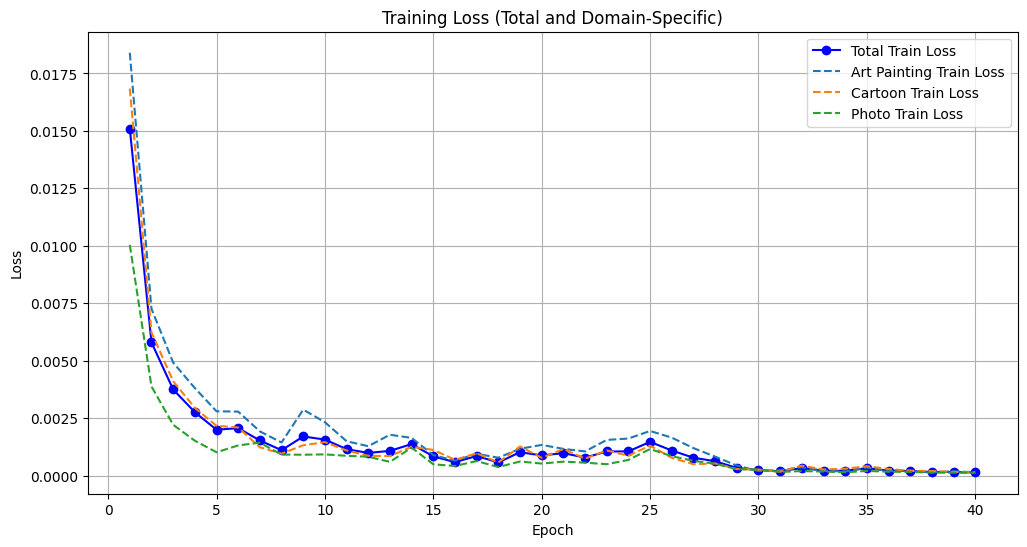

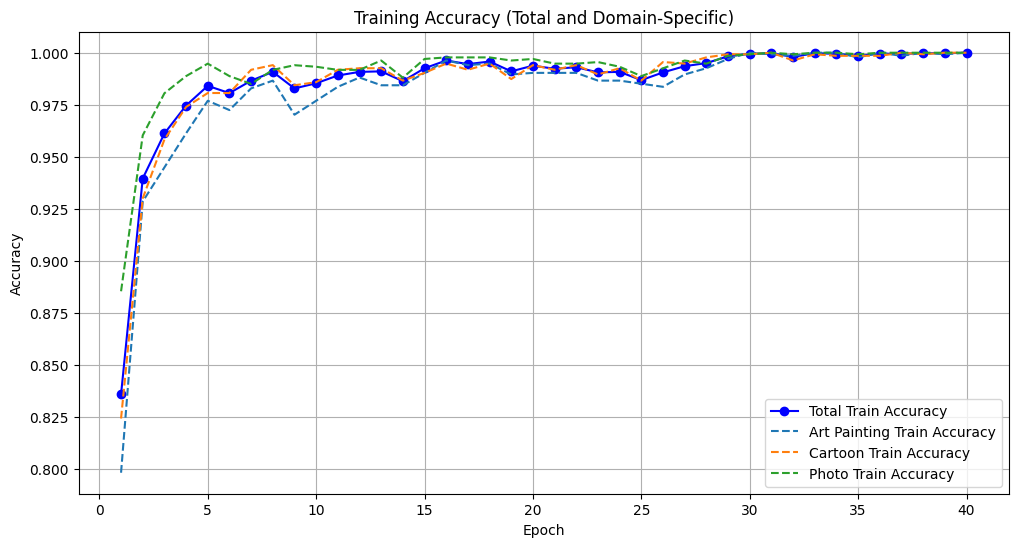

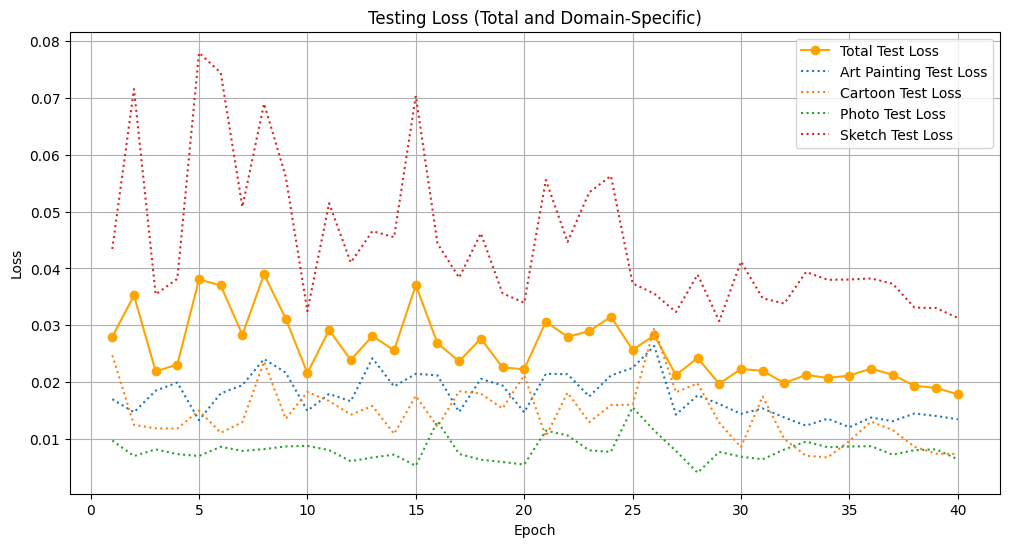

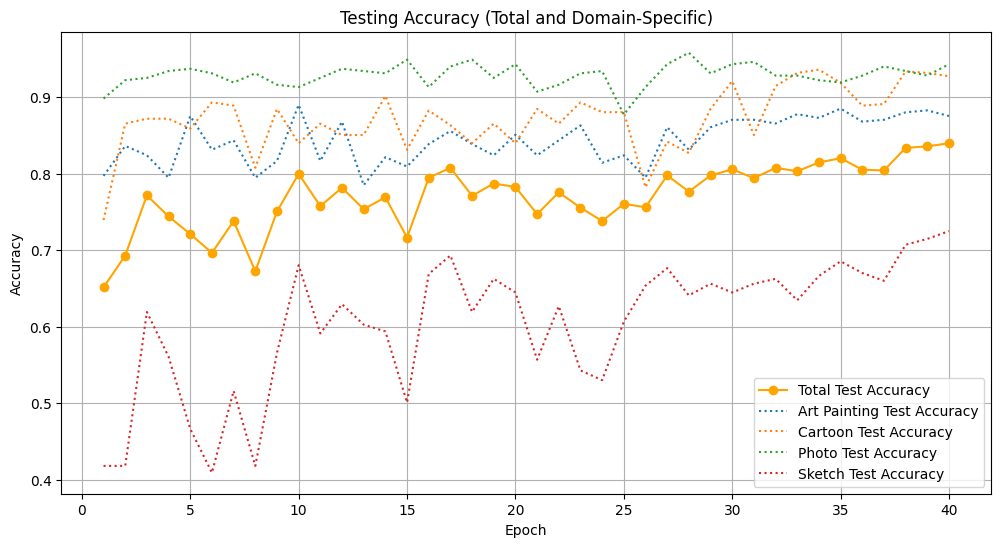

In [31]:
r = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
r.fc = nn.Linear(r.fc.in_features, 7)
resnet = ResnetFeature(r)
resnet.to(device)

# the oracle network
r_0 = torchvision.models.resnet18(weights= torchvision.models.ResNet18_Weights.DEFAULT)
r_0.fc = nn.Linear(r_0.fc.in_features, 7)
resnet_0 = ResnetFeature(r_0)
resnet_0.to(device)

me = MeanEncoder()
ve = VarianceEncoder(r.fc.in_features, init = 0.1)

miro = MIRO(me, ve)
miro.to(device)



lr = 0.0006
optimizer = optim.Adam(list(resnet.parameters()) + list(miro.parameters()), lr=lr)
criterion = nn.CrossEntropyLoss()

train_domains = ["Art Painting", "Cartoon", "Photo"]
test_domains = ["Art Painting", "Cartoon", "Photo", "Sketch"]

train_loaders = [art_painting_train_loader, cartoon_train_loader, photo_train_loader]
test_loaders = [art_painting_test_loader, cartoon_test_loader, photo_test_loader, sketch_test_loader]

results = train_miro(resnet, resnet_0, miro, train_loaders, test_loaders, optimizer, criterion, 40, 0.01)


plot_results(results, train_domains, test_domains)